In [299]:
# import all relevant packages

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import Ridge
import warnings

In [300]:
# increase plot label sizes for nice, large, readable labels in our report
plt.rcParams.update({'font.size': 16})

# ridge regression will throw warnings for a large enough polynomial, silence those for a clearner output
warnings.filterwarnings('ignore') 

In [301]:
def get_cagr(index_initial, index_final, months):
    # cagr, aka compound annual growth rate typically works with years: therefore, we convert months to years.
    years = months/12
    cagr = ((index_final/index_initial)**(1/years)-1)*100
    return cagr

In [302]:
# load the data: sc-val for value stocks, sc-gr for growth stocks
df_fed = pd.read_csv('FEDFUNDS.csv')
#df_sc = pd.read_csv('sc-val.csv')
df_sc = pd.read_csv('sc-gr.csv')

# PREPROCESSING: average the feature datapoints to monthly periodicity
df_sc = df_sc.groupby(pd.PeriodIndex(df_sc['DATE'], freq="M"))['VALUE'].mean().reset_index()

# give our columns distinctive names: the data from FRED labels both of them as "VALUE"
#val_value = "VAL_VALUE"
val_value = "GR_VALUE"

df_sc.rename(columns={'VALUE':val_value}, inplace=True)

# combine the interest rate dataset with a stock index dataset for further processing.
df_sc = df_fed.join(df_sc[val_value])

In [303]:
# pearson coefficient for linearity...
df_sc.corr('pearson')

,FEDFUNDS,GR_VALUE
FEDFUNDS,1.000000,-0.619385
GR_VALUE,-0.619385,1.000000


In [304]:
# spearman coefficient for monotonity...
df_sc.corr('spearman')

,FEDFUNDS,GR_VALUE
FEDFUNDS,1.000000,-0.857595
GR_VALUE,-0.857595,1.000000


In [305]:
feature_val = df_sc["FEDFUNDS"].to_numpy().reshape(-1,1)
label_val = df_sc[val_value].to_numpy()

# PREPROCESSING: apply logarithmic scaling to the label data
label_val = np.log10(label_val)

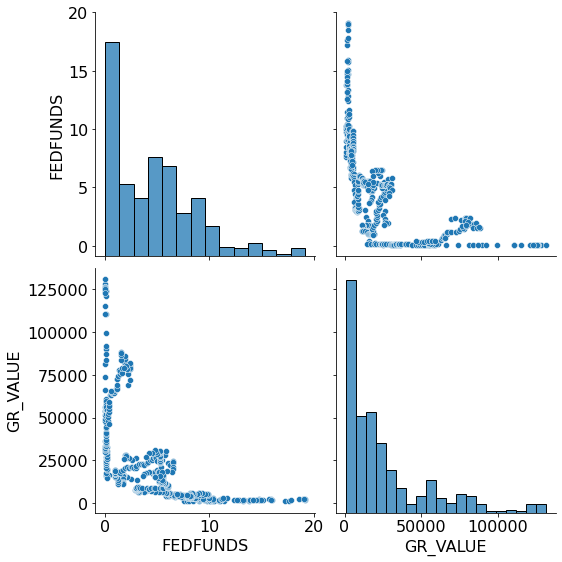

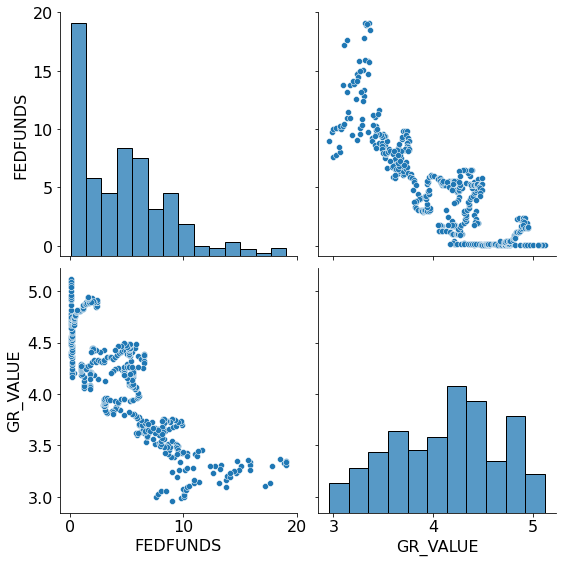

In [306]:
# sanity check to see label is normalized

# not normalized:
sns.pairplot(df_sc, height=4)

# # normalized
df_t = df_sc
df_t[val_value] = label_val
sns.pairplot(df_t, height=4)

In [307]:
# Split the dataset into a training set, validation set, and test set at a 80:10:10 ratio
X_train, X_rem, y_train, y_rem = train_test_split(feature_val, label_val, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

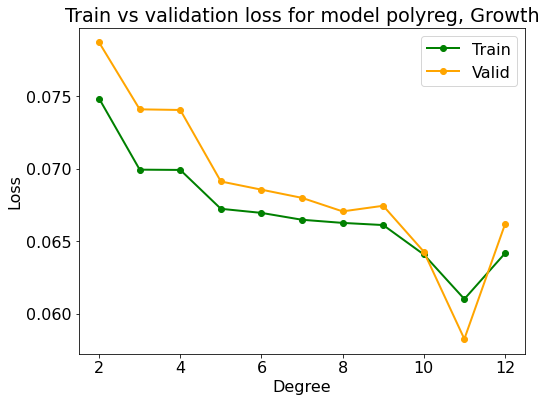

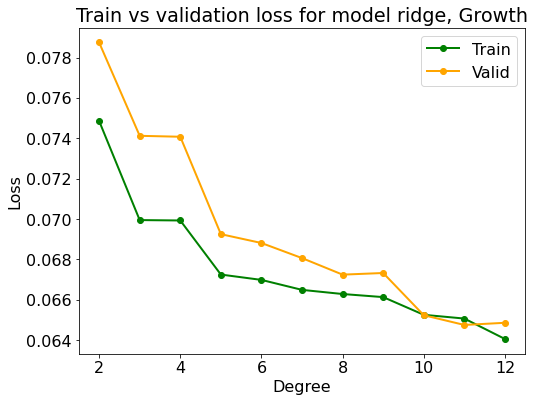

In [308]:
# Sections 4.1, 4.2

degrees = range(2,13)

def get_model_errors(model):

    tr_errors = []          
    val_errors = []

    for degree in degrees:
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)
        model.fit(X_train_poly, y_train)
        
        y_pred_train = model.predict(X_train_poly)
        y_pred_val = model.predict(X_val_poly)
        
        tr_error = mean_squared_error(y_train, y_pred_train)
        val_error = mean_squared_error(y_val, y_pred_val)
        tr_errors.append(tr_error)
        val_errors.append(val_error)
    
    return {"tr_errors": tr_errors, "val_errors": val_errors}

def plot_model_errors(data, model_type):
    plt.figure(figsize=(8, 6))

    plt.plot(degrees, data["tr_errors"], label = 'Train', marker='o', linewidth=2, color='green')
    plt.plot(degrees, data["val_errors"],label = 'Valid', marker='o', linewidth=2, color='orange')
    plt.legend(loc = 'upper right')

    plt.xlabel('Degree')
    plt.ylabel('Loss')
    plt.title('Train vs validation loss for model '+model_type+", Growth")
    plt.savefig(model_type+".png")
    plt.show()

model1 = LinearRegression()
model2 = Ridge(alpha = 1,  tol = 0.001, \
              solver ='auto')

# polynomial regression
poly = get_model_errors(model1)
# polynomial regression with ridge regularization applied
ridge = get_model_errors(model2)

plot_model_errors(poly, "polyreg")
plot_model_errors(ridge, "ridge")

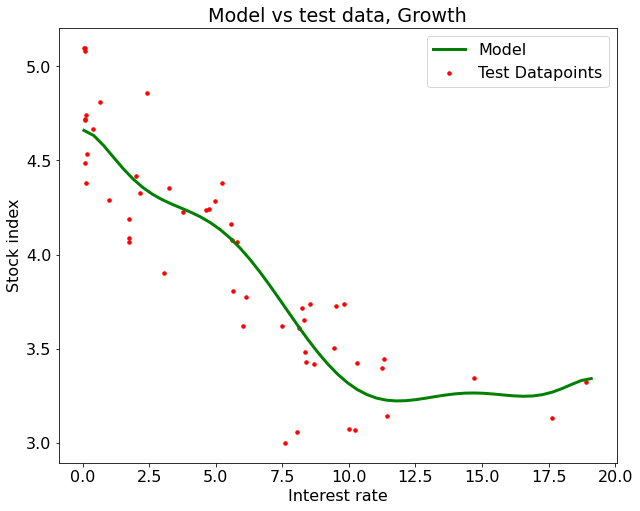

0.6440694133019867


In [309]:
#Section 4.3

def fit_given_model(model, fit_degree):
    poly = PolynomialFeatures(degree=fit_degree)
    X_train_poly = poly.fit_transform(X_train)
    model.fit(X_train_poly, y_train)

    return {"model": model, "poly": poly}

def plot_fitted_model(model, poly, features):
    plt.figure(figsize=(10, 8))
    prediction = model.predict(poly.transform(features.reshape(-1, 1)))
    test_error = mean_squared_error(y_test, prediction)
    plt.plot(features, prediction, label="Model", linewidth=3, color="green")
    plt.scatter(X_test, y_test, color="r", s=12, label="Test Datapoints")
    plt.xlabel('Interest rate')
    plt.ylabel('Stock index')
    plt.legend(loc="best")
    plt.title("Model vs test data, Growth")
    plt.savefig("final.png")
    plt.show()
    print(test_error)

def get_cagr_from_fitted_model(model, poly):
    features = np.linspace(np.min(feature_val), np.max(feature_val) , feature_val.size)
    prediction = model.predict(poly.transform(features.reshape(-1, 1)))
    log_prediction = 10**prediction
    cagr = get_cagr(np.min(log_prediction), np.max(log_prediction), log_prediction.size)
    print(cagr)


fitted_model = fit_given_model(model1, 8)
plot_fitted_model(fitted_model["model"], fitted_model["poly"],  np.linspace(np.min(feature_val), np.max(feature_val) , y_test.size))
#get_cagr_from_fitted_model(fitted_model["model"], fitted_model["poly"])